# Event finder 

This notebook will find "events" in the simplest definition i.e. a loser cell apoptosis or a winner cell 

To-do: 
- [x] Input HDF5 file which includes necessary information of x, y, t, fate
- [x] Identify a loser apoptosis x, y, t by invoking tracks[1] for Scr cells and sorting via fate by using tracks[1].fate
- [x] Define the exact time point of a loser cell apoptosis, how many frames it is classed as an apoptosis before the actual event (mainly ensuring false apoptoses aren’t included) 
- [ ] Screen all other tracks in the vicinity of previously obtained x, y, t by using if statement
- [ ] Screen further by excluding all tracks[0].fate =! division
- [ ] Repeat if statement for differing spatiotemporal ‘local environments’, increasing x, y, t  to count instances of mitosis across the whole monolayer over the whole experiment. 
- [ ] Assess viability of capturing a whole experiment in a single heat map, reduce scope if this is unviable. 

Refreshed to-do/different approach: 
- [x] find competitive event using list comprehension
- [x] remember how to find cells not using index but cell ID
- [x] write a function that parses that track(?) and finds local cells nearby


### Load data

In [5]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np

version no.: 0.4.0


In [6]:
filename ='/home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5'
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
#scr_tracks = (tracks[1]) 
#wt_tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/11/26 09:40:49 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/26 09:40:49 PM] Loading tracks/obj_type_1
[INFO][2020/11/26 09:40:52 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/11/26 09:40:55 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/11/26 09:40:55 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/26 09:40:55 PM] Loading tracks/obj_type_2
[INFO][2020/11/26 09:40:55 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/11/26 09:40:55 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


## Find event

#### Display track information

In [14]:
### this list comp shows scr cell IDs that have apoptosed and their length
[print("ID:", scr_track.ID, scr_track.fate.name, "length:", len(scr_track), "final time point:", scr_track.t[-1])  for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

ID: 1 APOPTOSIS length: 913 final time point: 912
ID: 3 APOPTOSIS length: 1176 final time point: 1175
ID: 4 APOPTOSIS length: 1175 final time point: 1174
ID: 6 APOPTOSIS length: 91 final time point: 91
ID: 10 APOPTOSIS length: 54 final time point: 171
ID: 11 APOPTOSIS length: 16 final time point: 175
ID: 16 APOPTOSIS length: 706 final time point: 1059
ID: 17 APOPTOSIS length: 388 final time point: 742
ID: 18 APOPTOSIS length: 199 final time point: 573
ID: 29 APOPTOSIS length: 349 final time point: 920
ID: 38 APOPTOSIS length: 3 final time point: 729
ID: 46 APOPTOSIS length: 7 final time point: 766
ID: 47 APOPTOSIS length: 167 final time point: 935
ID: 50 APOPTOSIS length: 371 final time point: 1175
ID: 54 APOPTOSIS length: 18 final time point: 900
ID: 56 APOPTOSIS length: 291 final time point: 1175
ID: 58 APOPTOSIS length: 289 final time point: 1175
ID: 60 APOPTOSIS length: 3 final time point: 892
ID: 65 APOPTOSIS length: 55 final time point: 967
ID: 66 APOPTOSIS length: 3 final time p

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Filter tracks to only include scr apoptosis

In [7]:
### scr_apop is all the scr tracks that have apoptosed
scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

##### Show the first classification of each track

In [4]:
for scr_track in scr_apops:
    print(scr_track.label[0], "ID is", scr_track.ID)

INTERPHASE ID is 1
INTERPHASE ID is 3
INTERPHASE ID is 4
APOPTOSIS ID is 6
APOPTOSIS ID is 10
APOPTOSIS ID is 11
ANAPHASE ID is 16
ANAPHASE ID is 17
ANAPHASE ID is 18
APOPTOSIS ID is 29
APOPTOSIS ID is 38
APOPTOSIS ID is 46
APOPTOSIS ID is 47
ANAPHASE ID is 50
APOPTOSIS ID is 54
APOPTOSIS ID is 56
APOPTOSIS ID is 58
APOPTOSIS ID is 60
APOPTOSIS ID is 65
APOPTOSIS ID is 66
APOPTOSIS ID is 67
APOPTOSIS ID is 71
APOPTOSIS ID is 72
APOPTOSIS ID is 74
APOPTOSIS ID is 78
APOPTOSIS ID is 82
APOPTOSIS ID is 85
APOPTOSIS ID is 87
APOPTOSIS ID is 90
APOPTOSIS ID is 96
APOPTOSIS ID is 98
APOPTOSIS ID is 99
APOPTOSIS ID is 100
APOPTOSIS ID is 102
APOPTOSIS ID is 105
APOPTOSIS ID is 111
APOPTOSIS ID is 112
APOPTOSIS ID is 119
APOPTOSIS ID is 120
APOPTOSIS ID is 122
APOPTOSIS ID is 124
APOPTOSIS ID is 135
APOPTOSIS ID is 140
APOPTOSIS ID is 141
APOPTOSIS ID is 142
APOPTOSIS ID is 143
APOPTOSIS ID is 150
APOPTOSIS ID is 152
APOPTOSIS ID is 153
APOPTOSIS ID is 158
APOPTOSIS ID is 162
APOPTOSIS ID is 1

## Isolating one track of interest

In [8]:
print("Input cell ID of interest")
cell_ID = int(input())
index = [i for i, scr_apop in enumerate(scr_apops) if scr_apop.ID == cell_ID][0]
target_track = scr_apops[index]##### Show the first classification of each track

Input cell ID of interest
17


#### check state classifications of this track

In [9]:
target_track.label

['ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHAS

## Find nearby cells 

In [10]:
target_track

,ID,t,x,y,z,parent,root,state,generation,dummy
0,17,354,592.089050,1121.349365,0.000000,2,2,3,1,False
1,17,355,599.770813,1122.750000,0.000000,2,2,3,1,False
2,17,356,597.294983,1122.762573,0.000000,2,2,3,1,False
3,17,357,595.140930,1121.939575,0.000000,2,2,3,1,False
4,17,358,596.659119,1121.590942,0.000000,2,2,3,1,False
5,17,359,598.070312,1123.187500,0.000000,2,2,3,1,False
6,17,360,601.812317,1124.481201,0.000000,2,2,3,1,False
7,17,361,606.079834,1126.327026,0.000000,2,2,3,1,False
8,17,362,608.422485,1126.737915,0.000000,2,2,0,1,False
9,17,363,610.502502,1127.165894,0.000000,2,2,0,1,False


### Functions to measure local neighbourhood for cells of interest

In [9]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(frame)
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_index(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            #apop_other_index = target_track.label.index("APOPTOSIS") ## this doesnt return the first of three classifications like i need
            break
    return apop_index

#### merge with above for two outputs?
def find_apoptosis_time(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    return apop_time

def find_nearby_wt(target_track, radius = 100, delta_t = 0):
    frame = apop_time + delta_t ## check the delta_t option 
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]##not strictly necessary to have this extra conditional bc scr/wt_tracks are different anyway #and wt_track != target_track]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    
    return wt_tracks_in_radius

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = apop_time + delta_t 
    dividing_states = ('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] in dividing_states]
    
    return wt_tracks_in_radius, wt_mitosis_in_radius

def maximum_xyt():
    max_x = int((max([max(i.x) for i in wt_tracks])))
    max_y = int((max([max(i.y) for i in wt_tracks])))
    max_t = int((max([max(i.t) for i in wt_tracks])))
    
    return max_x, max_y, max_t


In [10]:
apop_index = find_apoptosis_index(target_track)
apop_time = find_apoptosis_time(target_track)
nearby_cells = find_nearby_wt(target_track)
nearby_mitosis = find_nearby_wt_mitosis(target_track, 100, 100)

# to do

- [x] thus far i have nearby tracks that END in a mitosis, but i need nearby tracks that have a mitosis within delta_t of apop_time
- [x] put a circle of radius r on the diagram below
- [ ] check against raw data (ongoing work in raw_data_viewer notebook)
- [x] remove duplicates from nearby list
- [ ] start binning data into different delta_t and r
- [ ] plot that as a histogram type thing

The following cell returns the total number of wt nearby tracks, the total number of mitoses allowing for a probability of mitosis given the set params to be defined. 

In [10]:
radius = 3000
delta_t = 0 # time shift wrt apoptosis time
wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
print(P_mitosis)

0.024464831804281346


In [11]:
max_x, max_y, max_t = maximum_xyt()
print(max_t, max_y)

1175 1598


In [ ]:
radial_range = range(0,1600)
data = [None]* len(radial_range)
for radius in radial_range:
    delta_t = 0
    wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
    if len(wt_tracks_nearby) == 0:
        P_mitosis = 0
    else:
        P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
    data[(radius)] = P_mitosis

In [100]:
m = len(radial_range)
n = len(time_range)


1598 1175


In [106]:
max_x, max_y, max_t = maximum_xyt()
radial_range = range(0,max_y)
time_range = range(-apop_time, max_t-apop_time) ## 1200 is the total frame number
data = np.zeros((len(radial_range), len(time_range)))
number = np.zeros((len(radial_range), len(time_range)))
for radius in radial_range:
    for delta_t in time_range:
        wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
        if len(wt_tracks_nearby) == 0:
            P_mitosis = 0
        else:
            P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
        data[radius, delta_t] = P_mitosis
        number[radius, delta_t] = len(wt_mitosis_nearby)

KeyboardInterrupt: 

In [12]:
from tqdm.notebook import tnrange, tqdm


In [15]:
print('Total calculation progress bar below (n/N radii and timepoints):')
radial_range = range(0,max_y)
time_range = range(-apop_time, max_t-apop_time) ## 1200 is the total frame number
data = np.zeros((len(radial_range), len(time_range)))
number = np.zeros((len(radial_range), len(time_range)))
for radius in tqdm(radial_range):
    for delta_t in tqdm(time_range):
        wt_tracks_nearby, wt_mitosis_nearby = find_nearby_wt_mitosis(target_track, delta_t, radius)
        if len(wt_tracks_nearby) == 0:
            P_mitosis = 0
        else:
            P_mitosis = len(wt_mitosis_nearby) / len(wt_tracks_nearby)
        if len(wt_mitosis_nearby)>0:
            print("hit!")
        
        data[radius, delta_t] = P_mitosis
        number[radius, delta_t] = len(wt_mitosis_nearby)

Total calculation progress bar below (n/N radii and timepoints):


hit!



hit!



hit!



hit!



hit!



hit!
hit!



hit!
hit!



hit!
hit!



hit!
hit!
hit!



hit!
hit!
hit!



hit!
hit!
hit!



hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!



hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!
hit!


KeyboardInterrupt: 

In [16]:
print(number)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
apop_time

730

In [26]:
from matplotlib.pyplot import figure

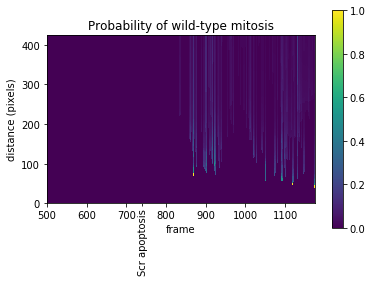

In [68]:
plt.imshow(data, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,425)
plt.xlim(500,1175)
plt.xlabel("frame")
plt.ylabel("distance (pixels)")
plt.text(730,-175, "Scr apoptosis -", rotation=90)
plt.title("Probability of wild-type mitosis")
plt.savefig("/home/nathan/data/output.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()


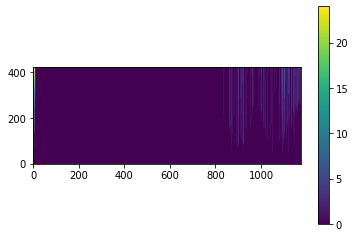

In [71]:
plt.imshow(number, cmap= 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,425)
plt.xlim(0,1175)
plt.savefig("/home/nathan/data/output.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.show()

In [74]:
euclidean_distance(target_track, wt_tracks_nearby[0], apop_time)

inf

In [75]:
wt_tracks_nearby[0]

,ID,t,x,y,z,parent,root,state,generation,dummy
0,316,425,613.350159,1276.885498,0.0,120,39,3,3,False
1,316,426,613.266418,1266.905762,0.0,120,39,3,3,False
2,316,427,618.071655,1263.114746,0.0,120,39,3,3,False
3,316,428,617.317566,1262.749268,0.0,120,39,3,3,False
4,316,429,613.947083,1261.058228,0.0,120,39,3,3,False
5,316,430,615.902466,1261.782715,0.0,120,39,2,3,False
6,316,431,616.446899,1262.720703,0.0,120,39,2,3,False
7,316,432,617.070129,1262.430664,0.0,120,39,0,3,False
8,316,433,617.144409,1259.404053,0.0,120,39,0,3,False
9,316,434,618.270386,1258.116333,0.0,120,39,0,3,False


In [34]:
delta_t = 100
radius = 100
nearby = []
for t in range(-delta_t, delta_t):
    #track = find_nearby_wt_mitosis(target_track, t, radius)
    nearby_mitosis += find_nearby_wt_mitosis(target_track, t, radius)
    nearby_mitosis_list = list(set(nearby_mitosis))

In [36]:
[t.ID for t in nearby_mitosis_list]

[720, 762, 721, 336, 407, 932, 353, 849, 316, 751]

### binning this data into discrete cats

In [76]:
### max length of track
max([len(wt_tracks[i]) for i, j in enumerate(wt_tracks)])

1105

In [80]:
### max t value
max([wt_tracks[i].t[-1] for i, j in enumerate(wt_tracks)])

1175

In [132]:
### range needs to be apop_time -> t[-1]

## if apop_time = 600 then we need (0, 1200)
t_range = range(-apop_time, 1200-apop_time, 100)
print(t_range)

range(-730, 470, 100)


In [121]:
T=-730

In [129]:
### define Delta_T bin size
#t_range = range(0, 1200, 100)
radius = 100
time_step = 100
t_range = range(-apop_time, 1200-apop_time, time_step) ## this defines the minimum time point as 0 (ie -apop_time from apop_time) and the max time point as the max no. frames-the apop_time
for T in t_range: 
    print(T)
    for t in range(T, T+time_step): #from t to t+step
        print(t)
        track = find_nearby_wt_mitosis(target_track, t, radius)
        if any(i in [t.ID for t in track] for i in [t.ID for t in nearby]):
            print("duplicate")
        else:
            #print("division event found")
            nearby += track
    print("ID of nearby wt mito is", [t.ID for t in nearby])
    mito_dict = {T: nearby}
    #mitosis_dict = {T: nearby} ### this is still overwriting
    mitosis_dict.update({T: nearby})

-730
-730
-729
-728
-727
-726
-725
-724
-723
-722
-721
-720
-719
-718
-717
-716
-715
-714
-713
-712
-711
-710
-709
-708
-707
-706
-705
-704
-703
-702
-701
-700
-699
-698
-697
-696
-695
-694
-693
-692
-691
-690
-689
-688
-687
-686
-685
-684
-683
-682
-681
-680
-679
-678
-677
-676
-675
-674
-673
-672
-671
-670
-669
-668
-667
-666
-665
-664
-663
-662
-661
-660
-659
-658
-657
-656
-655
-654
-653
-652
-651
-650
-649
-648
-647
-646
-645
-644
-643
-642
-641
-640
-639
-638
-637
-636
-635
-634
-633
-632
-631
ID of nearby wt mito is [932, 147, 316, 317, 121, 170, 353, 167, 368, 148, 380, 381, 206, 604, 318, 720, 751, 762, 336, 849, 407, 721]
-630
-630
-629
-628
-627
-626
-625
-624
-623
-622
-621
-620
-619
-618
-617
-616
-615
-614
-613
-612
-611
-610
-609
-608
-607
-606
-605
-604
-603
-602
-601
-600
-599
-598
-597
-596
-595
-594
-593
-592
-591
-590
-589
-588
-587
-586
-585
-584
-583
-582
-581
-580
-579
-578
-577
-576
-575
-574
-573
-572
-571
-570
-569
-568
-567
-566
-565
-564
-563
-562
-561
-560


In [130]:
print(mito_dict)

{370: [OrderedDict([('ID', 932), ('t', [704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 

In [131]:
print(mitosis_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [112]:
print(len(bins))

1


# checking against raw data

In [46]:
[t.ID for t in nearby]

[316, 720, 353, 751, 762, 336, 849, 407, 721, 932]

In [53]:
nearby[0]

,ID,t,x,y,z,parent,root,state,generation,dummy
0,316,425,613.350159,1276.885498,0.0,120,39,3,3,False
1,316,426,613.266418,1266.905762,0.0,120,39,3,3,False
2,316,427,618.071655,1263.114746,0.0,120,39,3,3,False
3,316,428,617.317566,1262.749268,0.0,120,39,3,3,False
4,316,429,613.947083,1261.058228,0.0,120,39,3,3,False
5,316,430,615.902466,1261.782715,0.0,120,39,2,3,False
6,316,431,616.446899,1262.720703,0.0,120,39,2,3,False
7,316,432,617.070129,1262.430664,0.0,120,39,0,3,False
8,316,433,617.144409,1259.404053,0.0,120,39,0,3,False
9,316,434,618.270386,1258.116333,0.0,120,39,0,3,False


In [50]:
print("xyt of target apoptosis")
target_track.x[apop_index], target_track.y[apop_index], apop_time

xyt of target apoptosis


(550.5511474609375, 1089.223876953125, 730)

# display tracks

In [38]:
#### image dimensions hack
target_track.x[apop_index], target_track.y[apop_index]
max_x = (max([max(i.x) for i in wt_tracks]))
max_y = (max([max(i.y) for i in wt_tracks]))
max_t = (max([max(i.t) for i in wt_tracks]))
print(max_x, max_y, max_t)

1199.943115234375 1598.439208984375 1175


In [54]:
import matplotlib.pyplot as plt

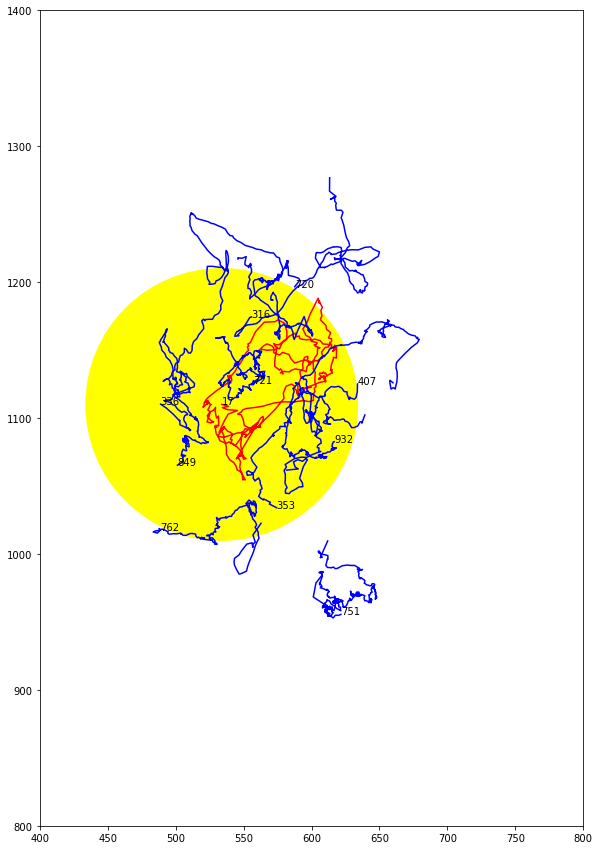

In [67]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 100,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.ylim(800,1400)
plt.xlim(400, 800)
figure.set_size_inches(15, 15)
plt.show()

### example of delta_t 100 and radius 500

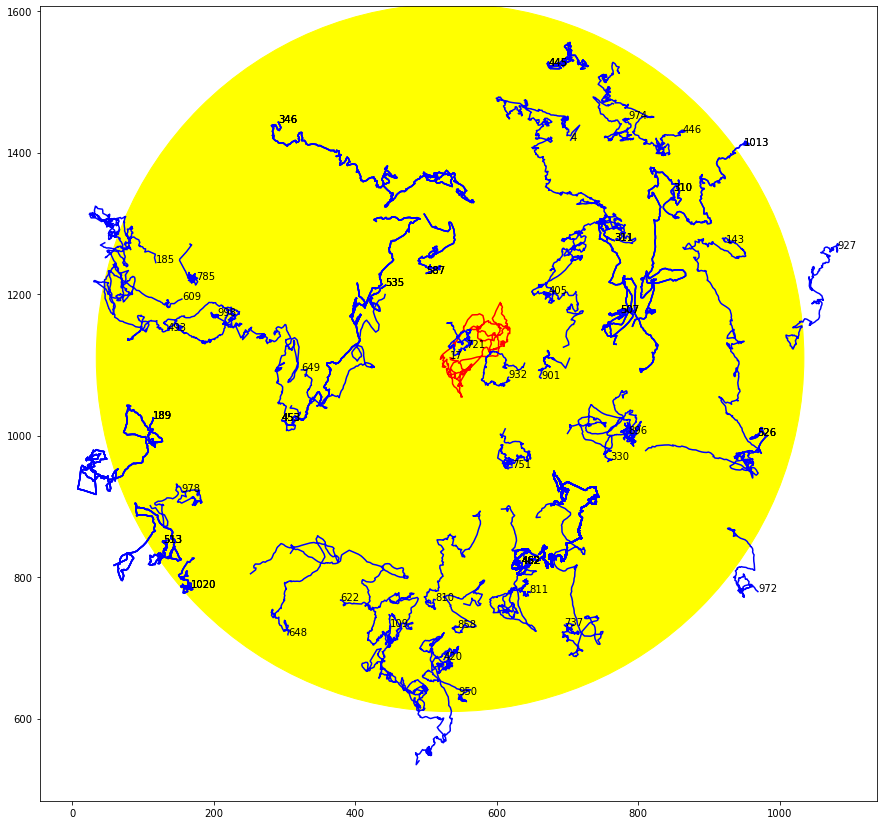

In [21]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 500,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
# plt.xlim(0,1200)
# plt.ylim(0,1200)
figure.set_size_inches(15, 15)
plt.show()

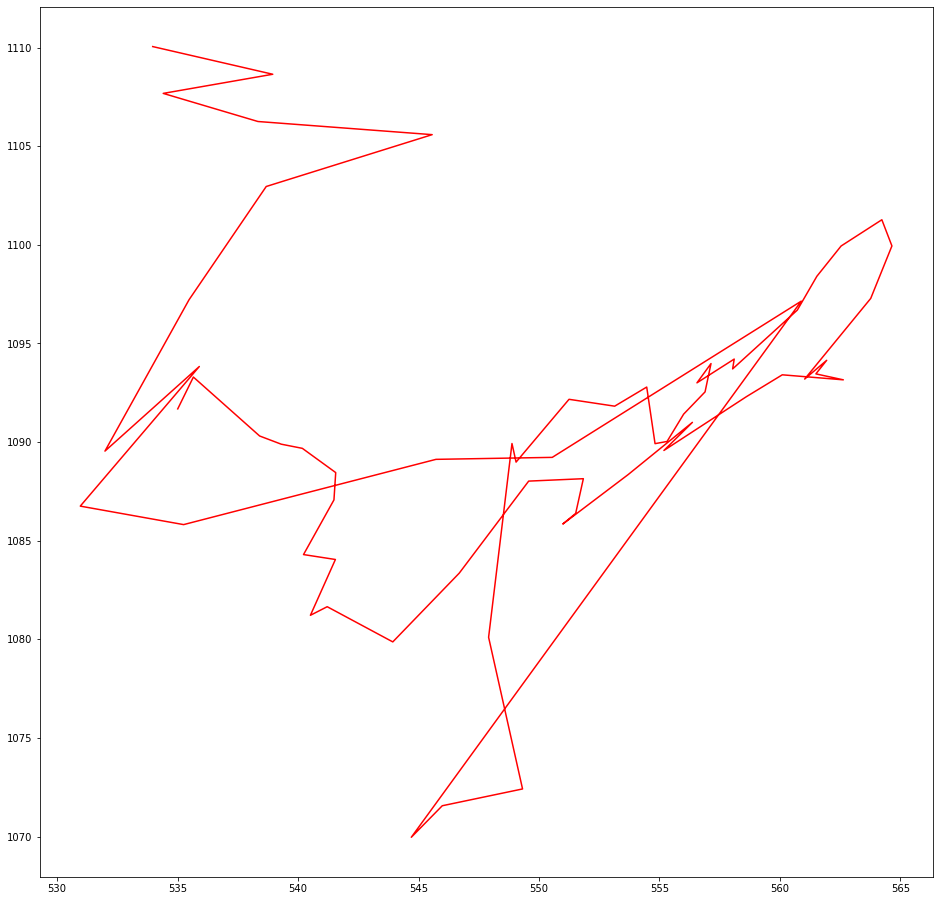

In [57]:
plt.figure(figsize=(16,16))
plt.plot(target_track.x[apop_index-50: apop_index+50], target_track.y[apop_index-50: apop_index+50], 'r-')
# for track in nearby:
#     plt.plot(track.x, track.y, 'b-')
# for mitosis in nearby_mitosis:
#     plt.plot(mitosis.x, mitosis.y, 'g-')


plt.show()

###### misc

In [254]:
#### old nearby list, created issue with list entry
delta_t = 2
old_nearby = []
for t in range(-delta_t, delta_t):
    old_nearby.append(find_nearby_wt_mitosis(target_track, t))
    old_nearby = list(filter(None, old_nearby))
# for i, j in enumerate(nearby): ### BAD HACK needs solving: each entry in the nearby list is entered as a list itself, not a btrack tracklet, so need to redefine as first item in list
#     nearby[i] = nearby[i][0] 

In [ ]:
### ideas i showed guillaume when explaining plan, keeping for future reference

wt_track.label[apop_time] == "DIVIDE"
nearby_mitosis_plust = find_nearby_wt_mitosis(target_track, 200)

In [ ]:
print(target_track.label)
apop_frames = [i for i, j in enumerate(target_track.label) if j == "APOPTOSIS"]
target_track.label[-1]

In [ ]:
wt_tracks[0].label

In [ ]:
wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]

want the below conditional to be ```if wt_track.label[wt_track.t.index(apop_time +- delta_t)] == "APOPTOSIS"```

In [ ]:
### want the conditional to be if wt
wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] == "DIVIDE"]

In [ ]:
##rewriting the list comprehension as a for loop to see if the conditional statement can be achieved

for wt_track in wt_tracks_in_radius:
    if wt_track.fate.name == "DIVIDE":
        
        if wt_track.label[wt_track.t.index(apop_time)] == "DIVIDE":
        ### something to store a mitosis at apop_time
    if wt_track

In [ ]:
wt_track.label[0] ## here we have the state at index 0, and want the state at t = apop_t

## want label at t
track = wt_tracks_in_frame[0]
track_2 = wt_tracks_in_frame[-1]

In [ ]:
### this line pulls the classification from the apoptosis time
track.label[track.t.index(apop_time)]

In [ ]:
### this pulls the index from the time
track.t.index(apop_time)

In [ ]:
target_track.label[target_track.t.index(apop_time)]

In [ ]:
target_track

In [ ]:
apop_time

In [ ]:
wt_tracks_in_frame[0]

In [ ]:
wt_tracks_in_frame[-]